## This notebook describes my imputation procedure for filling in missing values in my edge properties.

In [189]:
# Imports and miscellany

import csv
import itertools
import pickle
import string
import graphHandler as gh
import inventoryCleaner as iC
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

# Helper functions

def representsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def buildRange(x):
    result = []
    if pd.isnull(x)==True:
        return np.nan
    for part in x.split(','):
        if '-' in part:
            a, b = part.split('-')
            if (representsInt(a)==False):
                strarr = []
                for i in range(ord(a), ord(b)+1):
                    strarr.append(chr(i))
                result.extend(strarr)
            else:
                a, b = int(a), int(b)
                result.extend(range(a, b + 1))
        else:
            if (representsInt(part)==False):
                result.append(part)
            else:
                a = int(part)
                result.append(a)
    return result

def existin(x):
    r = reqs[reqs['Variable']==x]['Reasonable range'].tolist()
    return r

def returnProps(net, u, v, prop):
    return net[u][v][prop]

def returnNeighborProps(net,u,v,props):
    propertyTracker = {el:[] for el in props}
    neighbors = net.neighbors(u)
    for n in neighbors:
        for p in props:
            newp = returnProps(net, u, n, p)
            if (type(newp)=='NoneType')==False:
                propertyTracker[p].append(newp)
    neighbors = net.neighbors(v)
    for n in neighbors:
        for p in props:
            newp = returnProps(net, n, v, p)
            if (type(newp)=='NoneType')==False:
                propertyTracker[p].append(newp)
    return propertyTracker

def getConsensus(props, reqs):
# This function takes in a dict of missing properties and returns the appropriate value after
# accounting for categorical or numerical.
    bestGuess = {el:0 for el in props}
    for key in props:
        iscategorical = reqs.ix[reqs['Variable']==key, 'Categorical']
        if iscategorical.values[0]:
            bestGuess[key]=np.random.choice(props[key])
        else:
            bestGuess[key]=np.mean(props[key])
    return bestGuess

In [196]:
# The first step is to bring in a CSV full of properties and requirements for my data set. 

pathtoreqs = '/home/louisf/Documents/Insight/massdriver/docs/road_inventory_params.csv'
reqs = pd.read_csv(pathtoreqs, delimiter = '^')

In [197]:
# Do a little bit of cleaning to convert some stuff and drop some rows
reqs['Reasonable range'] = reqs['Reasonable range'].map(buildRange)
reqs = reqs[reqs['Disqualify']==False]

In [200]:
# Load in my database 
fpath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RoadInventory.geojson'
pdinv = iC.PDInventory('roadInventory', 'test')
pdinv.geojsontodf(fpath)

toy = pdinv.table
for colname in toy.columns:
    if (sum(colname==reqs['Variable'])!=1):
        toy.drop(colname, inplace=True, axis=1)
        


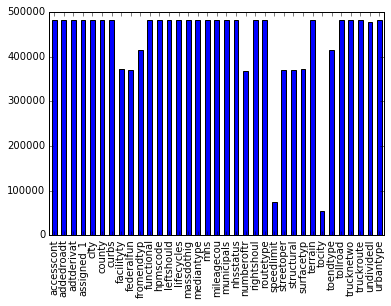

In [103]:
# Check on how many of the remaining features exceed some threshold of in-range values.

df = pd.DataFrame(index=toy.columns,columns=['value', 'hasbounds'])

for colname in toy.columns:
    nrange = existin(colname)[0]
    if type(nrange)!=float:
        df.loc[colname]= sum(toy[colname].isin(nrange))
        
for row in df.index:
    r = existin(row)[0]
    if type(r) == float:
        df.loc[row]['hasbounds'] = False
    else:
        df.loc[row]['hasbounds'] = True

# Examine only entries with bounds for removal:

df.loc[df['hasbounds']==True]
df.loc[df['hasbounds']==True].value.plot(kind='bar')

# Drop all entries with fewer than 10% of values within bounds
df = df[df['value']<50000]

# The indices of df correspond to all of the properties we will drop from our table.

# Based on this inspection, we will drop:
# fromcity
# fromstate
# iristatus
# jurisdicti
# opposingdi
# oppositenu
# tostate

# This removal occurs in road_inventory_params.

In [ ]:
# Next, I will load in my graph. I will use the pickle I generated previously.
picklepath = '/home/louisf/Documents/Insight/massdriver/notebooks/graph_with_risk2.pickle'
graph = nx.read_gpickle(picklepath)

In [ ]:
newNet = graph.net

In [ ]:
# Just kidding! I need to generate a new graph with all of the properties I am interested in.

graph = gh.NetworkGenerator()
filepath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RI_converted.shp'
graph.loadGraph(filepath=filepath, fields=toy.columns.tolist(), simplify=True)
newNet = graph.net

In [ ]:
# Iterate over each edge. Find the properties on that edge that are missing. 
importantProperties = toy.columns.tolist()
nrange = reqs['Reasonable range']
it=0
for u,v in newNet.edges_iter():
    g = newNet[u][v]
    missingProps = []
    for props in importantProperties:
        nrange = reqs.loc[reqs['Variable']==props]['Reasonable range']
        if len(nrange.tolist())>0:
            if type(nrange.tolist()[0])!=float:
                if ((g[props] in nrange.tolist()[0])==False):
                    missingProps.append(props)
    neighborProps = returnNeighborProps(newNet, u, v, missingProps)
    newvals = getConsensus(neighborProps, reqs)
    for key, value in newvals.items():
        newNet[u][v][key]=value
    if(it%10000==0):
        print(it)
    it+=1


0


In [180]:
v

(-71.54779056938288, 42.402973076118116)

In [152]:
np.random.choice(p['county'])

'I'

In [209]:
it=0
for u,v in newNet.edges_iter():
    g = newNet[u][v]
    missingProps = []
    for props in importantProperties:
        nrange = reqs.loc[reqs['Variable']==props]['Reasonable range']
        if len(nrange.tolist())>0:
            if type(nrange.tolist()[0])!=float:
                if ((g[props] in nrange.tolist()[0])==False):
                    missingProps.append(props)
    it+=1
    break

In [212]:
missingProps

[]

In [145]:
iscategorical.values[0]

True

In [ ]:
import itertools
list(itertools.chain(*neighbors))

In [ ]:
nx.write_gpickle(graph.net, '/home/louisf/Documents/Insight/massdriver/data/largeGraph.npickle')

In [2]:
newNet = nx.read_gpickle('/home/louisf/Documents/Insight/massdriver/data/largeGraph.npickle')

In [ ]:
# For each node on the edge, find the properties of the edges attached to that node.

In [ ]:
# Find all properties that are with an acceptable range within that set, and use those to impute missing value.